In [ ]:
!pip install torch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=a3496cdd9a634ba3aff567b444c339ae7aa981e4247fdfd24400a99d21831e03
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [ ]:
import torch
import torch.nn as nn
import torch_optimizer as optim_look
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

from minisom import MiniSom


In [ ]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

    def embed(self, x):
        return self.encoder(x)



In [ ]:

input_size = 784
latent_size = 128
learning_rate = 0.002
batch_size = 128
epochs = 40
warmup_epochs = 2


In [ ]:

som_grid_rows = 20
som_grid_cols = 20
sigma = 1.5
learning_rate_som = 0.3
num_iterations = 10000

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.05MB/s]


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_size, latent_size).to(device)
criterion = nn.BCELoss()
base_optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = optim_look.Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.002, step_size_up=200, mode='triangular')


In [ ]:

model.train()
for epoch in range(epochs):
    total_loss = 0
    for data, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        data = data.to(device)
        recon, z = model(data)
        recon_loss = criterion(recon, data)
        reg_loss = 0.02 * torch.norm(z, p=2)
        loss = recon_loss + reg_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


        if epoch < warmup_epochs:
            current_lr = learning_rate * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_loss:.4f}")

Epoch 1/40: 100%|██████████| 469/469 [00:12<00:00, 37.88it/s]


Epoch [1/40] - Loss: 0.2448


Epoch 2/40: 100%|██████████| 469/469 [00:09<00:00, 51.85it/s]


Epoch [2/40] - Loss: 0.1689


Epoch 3/40: 100%|██████████| 469/469 [00:08<00:00, 52.33it/s]


Epoch [3/40] - Loss: 0.1490


Epoch 4/40: 100%|██████████| 469/469 [00:08<00:00, 55.50it/s]


Epoch [4/40] - Loss: 0.1452


Epoch 5/40: 100%|██████████| 469/469 [00:09<00:00, 51.59it/s]


Epoch [5/40] - Loss: 0.1441


Epoch 6/40: 100%|██████████| 469/469 [00:09<00:00, 50.30it/s]


Epoch [6/40] - Loss: 0.1407


Epoch 7/40: 100%|██████████| 469/469 [00:10<00:00, 45.47it/s]


Epoch [7/40] - Loss: 0.1354


Epoch 8/40: 100%|██████████| 469/469 [00:08<00:00, 56.00it/s]


Epoch [8/40] - Loss: 0.1315


Epoch 9/40: 100%|██████████| 469/469 [00:09<00:00, 51.88it/s]


Epoch [9/40] - Loss: 0.1305


Epoch 10/40: 100%|██████████| 469/469 [00:09<00:00, 51.92it/s]


Epoch [10/40] - Loss: 0.1308


Epoch 11/40: 100%|██████████| 469/469 [00:09<00:00, 51.81it/s]


Epoch [11/40] - Loss: 0.1304


Epoch 12/40: 100%|██████████| 469/469 [00:08<00:00, 55.45it/s]


Epoch [12/40] - Loss: 0.1299


Epoch 13/40: 100%|██████████| 469/469 [00:09<00:00, 50.87it/s]


Epoch [13/40] - Loss: 0.1260


Epoch 14/40: 100%|██████████| 469/469 [00:09<00:00, 52.11it/s]


Epoch [14/40] - Loss: 0.1232


Epoch 15/40: 100%|██████████| 469/469 [00:08<00:00, 52.20it/s]


Epoch [15/40] - Loss: 0.1254


Epoch 16/40: 100%|██████████| 469/469 [00:08<00:00, 55.80it/s]


Epoch [16/40] - Loss: 0.1238


Epoch 17/40: 100%|██████████| 469/469 [00:08<00:00, 52.21it/s]


Epoch [17/40] - Loss: 0.1246


Epoch 18/40: 100%|██████████| 469/469 [00:09<00:00, 51.88it/s]


Epoch [18/40] - Loss: 0.1216


Epoch 19/40: 100%|██████████| 469/469 [00:08<00:00, 52.36it/s]


Epoch [19/40] - Loss: 0.1193


Epoch 20/40: 100%|██████████| 469/469 [00:08<00:00, 54.98it/s]


Epoch [20/40] - Loss: 0.1178


Epoch 21/40: 100%|██████████| 469/469 [00:08<00:00, 52.29it/s]


Epoch [21/40] - Loss: 0.1177


Epoch 22/40: 100%|██████████| 469/469 [00:09<00:00, 51.91it/s]


Epoch [22/40] - Loss: 0.1184


Epoch 23/40: 100%|██████████| 469/469 [00:08<00:00, 54.53it/s]


Epoch [23/40] - Loss: 0.1180


Epoch 24/40: 100%|██████████| 469/469 [00:08<00:00, 53.89it/s]


Epoch [24/40] - Loss: 0.1167


Epoch 25/40: 100%|██████████| 469/469 [00:08<00:00, 52.45it/s]


Epoch [25/40] - Loss: 0.1142


Epoch 26/40: 100%|██████████| 469/469 [00:08<00:00, 52.68it/s]


Epoch [26/40] - Loss: 0.1136


Epoch 27/40: 100%|██████████| 469/469 [00:08<00:00, 56.40it/s]


Epoch [27/40] - Loss: 0.1142


Epoch 28/40: 100%|██████████| 469/469 [00:08<00:00, 52.67it/s]


Epoch [28/40] - Loss: 0.1139


Epoch 29/40: 100%|██████████| 469/469 [00:08<00:00, 52.36it/s]


Epoch [29/40] - Loss: 0.1150


Epoch 30/40: 100%|██████████| 469/469 [00:08<00:00, 52.69it/s]


Epoch [30/40] - Loss: 0.1116


Epoch 31/40: 100%|██████████| 469/469 [00:08<00:00, 55.90it/s]


Epoch [31/40] - Loss: 0.1105


Epoch 32/40: 100%|██████████| 469/469 [00:08<00:00, 52.70it/s]


Epoch [32/40] - Loss: 0.1094


Epoch 33/40: 100%|██████████| 469/469 [00:08<00:00, 52.56it/s]


Epoch [33/40] - Loss: 0.1093


Epoch 34/40: 100%|██████████| 469/469 [00:08<00:00, 53.69it/s]


Epoch [34/40] - Loss: 0.1094


Epoch 35/40: 100%|██████████| 469/469 [00:08<00:00, 54.87it/s]


Epoch [35/40] - Loss: 0.1084


Epoch 36/40: 100%|██████████| 469/469 [00:08<00:00, 52.52it/s]


Epoch [36/40] - Loss: 0.1072


Epoch 37/40: 100%|██████████| 469/469 [00:08<00:00, 52.51it/s]


Epoch [37/40] - Loss: 0.1060


Epoch 38/40: 100%|██████████| 469/469 [00:08<00:00, 55.56it/s]


Epoch [38/40] - Loss: 0.1063


Epoch 39/40: 100%|██████████| 469/469 [00:08<00:00, 53.03it/s]


Epoch [39/40] - Loss: 0.1056


Epoch 40/40: 100%|██████████| 469/469 [00:08<00:00, 52.69it/s]

Epoch [40/40] - Loss: 0.1058


In [ ]:

model.eval()
all_embeddings, all_labels = [], []
with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        embeddings = model.embed(data)
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.append(labels.numpy())

X = np.vstack(all_embeddings)
y = np.hstack(all_labels)


In [ ]:

X_norm = normalize(X)

som = MiniSom(som_grid_rows, som_grid_cols, input_len=latent_size, sigma=sigma, learning_rate=learning_rate_som)
som.random_weights_init(X_norm)
som.train_random(X_norm, num_iterations)


som_clusters = np.zeros(len(X_norm), dtype=int)
for i, x in enumerate(X_norm):
    w = som.winner(x)
    som_clusters[i] = w[0] * som_grid_cols + w[1]


In [ ]:
# Evaluation
sil_score = silhouette_score(X_norm, som_clusters)
db_index = davies_bouldin_score(X_norm, som_clusters)
ch_index = calinski_harabasz_score(X_norm, som_clusters)
print(f"\nSOM Silhouette Score: {sil_score:.4f}")
print(f"SOM Davies-Bouldin Index: {db_index:.4f}")
print(f"SOM Calinski-Harabasz Index: {ch_index:.4f}")




SOM Silhouette Score: 0.0337
SOM Davies-Bouldin Index: 2.9489
SOM Calinski-Harabasz Index: 168.0099


In [ ]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)


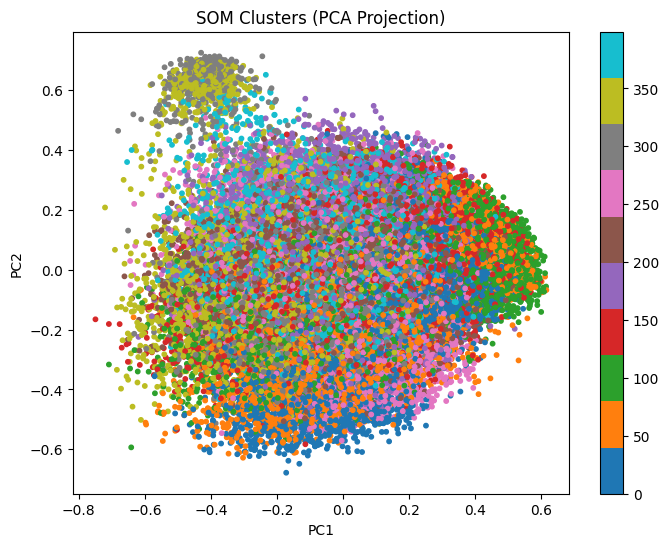

In [ ]:
# Plot 1: SOM Clusters (PCA)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=som_clusters, cmap='tab10', s=10)
plt.title("SOM Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()


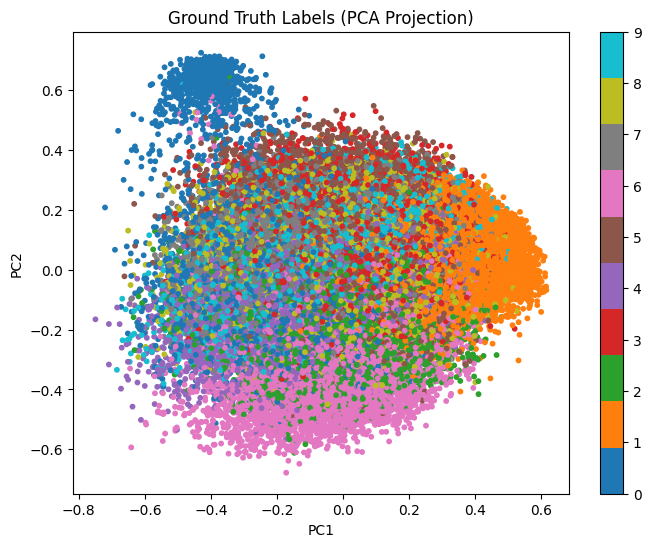

In [ ]:
# Plot 2: Ground Truth (PCA)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10)
plt.title("Ground Truth Labels (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

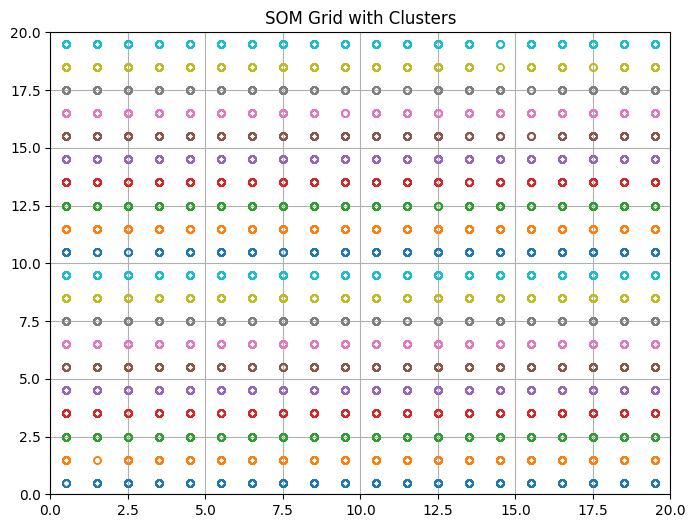

In [ ]:
# Plot 5: SOM Cluster Grid
plt.figure(figsize=(8, 6))
plt.title("SOM Grid with Clusters")
for i, x in enumerate(X_norm):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='None',
             markeredgecolor=plt.cm.tab10(som_clusters[i] % 10), markersize=5, markeredgewidth=1)
plt.xlim([0, som_grid_rows])
plt.ylim([0, som_grid_cols])
plt.grid()
plt.show()

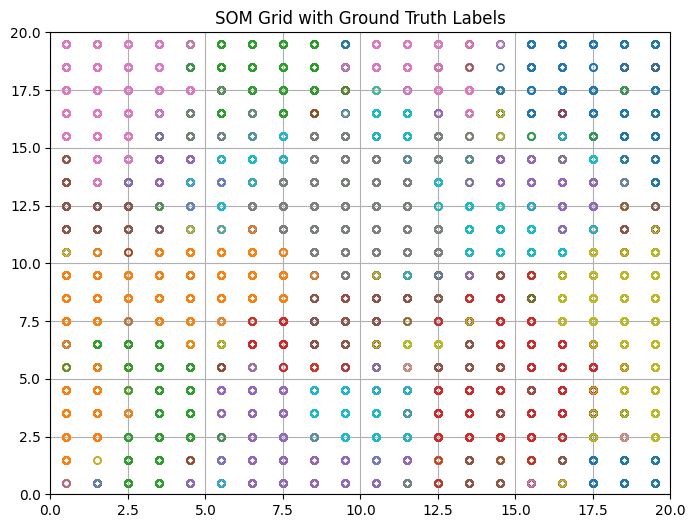

In [ ]:
# Plot 6: SOM Grid with Ground Truth
plt.figure(figsize=(8, 6))
plt.title("SOM Grid with Ground Truth Labels")
for i, x in enumerate(X_norm):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='None',
             markeredgecolor=plt.cm.tab10(y[i] % 10), markersize=5, markeredgewidth=1)
plt.xlim([0, som_grid_rows])
plt.ylim([0, som_grid_cols])
plt.grid()
plt.show()

In [ ]:

som_grid_rows = 15
som_grid_cols = 15


som = MiniSom(som_grid_rows, som_grid_cols, input_len=latent_size, sigma=sigma, learning_rate=learning_rate_som)
som.random_weights_init(X_norm)
som.train_random(X_norm, num_iterations)


som_clusters = np.zeros(len(X_norm), dtype=int)
for i, x in enumerate(X_norm):
    w = som.winner(x)
    som_clusters[i] = w[0] * som_grid_cols + w[1]


sil_score = silhouette_score(X_norm, som_clusters)
db_index = davies_bouldin_score(X_norm, som_clusters)
ch_index = calinski_harabasz_score(X_norm, som_clusters)
print(f"\nSOM Silhouette Score (15x15): {sil_score:.4f}")
print(f"SOM Davies-Bouldin Index (15x15): {db_index:.4f}")
print(f"SOM Calinski-Harabasz Index (15x15): {ch_index:.4f}")


SOM Silhouette Score (15x15): 0.0476
SOM Davies-Bouldin Index (15x15): 3.0163
SOM Calinski-Harabasz Index (15x15): 251.9404
